In [1]:
%matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.interpolate

In [2]:
raw_img = skimage.io.imread('campus.tiff')

In [3]:
print(f'size {raw_img.shape}, min value {raw_img.min()}, max value {raw_img.max()}, type {raw_img.dtype}') # 16 bit unsigned int

size (4016, 6016), min value 147, max value 4087, type uint16


In [8]:
def plot_fig(fig1, fig2, name='img_temp.png'):
    fig = plt.figure(figsize=(14, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.axis('off')
    plt.savefig(name)

    plt.show()
def linearize_image(img, dark, sat):
    img_transform = (img - dark) / (sat - dark)
    img_final = np.clip(img_transform, 0, 1)
    return img_final

In [11]:
lin_img = linearize_image(raw_img, 150, 4095)

In [12]:
def extract_colors_bayer(name):
    if name == 'grbg':
        G1 = lin_img[0::2, 0::2] # s01
        B = lin_img[1::2, 0::2] # s10
        R = lin_img[0::2, 1::2] # s01
        G2 = lin_img[1::2, 1::2] # s11

    elif name == 'rggb':
        R = lin_img[0::2, 0::2]
        G1 = lin_img[1::2, 0::2]
        G2 = lin_img[0::2, 1::2]
        B = lin_img[1::2, 1::2]
        
    elif name == 'bggr':
        B = lin_img[0::2, 0::2]
        G1 = lin_img[1::2, 0::2]
        G2 = lin_img[0::2, 1::2]
        R = lin_img[1::2, 1::2]

        
    elif name == 'gbrg':
        G1 = lin_img[0::2, 0::2]
        R = lin_img[1::2, 0::2]
        B = lin_img[0::2, 1::2]
        G2 = lin_img[1::2, 1::2]
        
    return R, G1, G2, B

In [13]:
R, G1, G2, B = extract_colors_bayer('bggr')

In [94]:
# white balance?
def preset_white_balancing(img):
    '''
    multipliers 2.394531 1.000000 1.597656 1.000000
    '''
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    R = R * 2.394531
    B = B * 1.597656
    return np.dstack((R, G, B))

def white_world_balancing(img):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    ru, gu, bu = R.max(), G.max(), B.max()
    print(ru, gu, bu)
    
    R = R * (gu / ru)
    G = G * 1
    B = B * (gu / bu)
    
    return np.dstack((R, G, B))

## Demosaic 

In [17]:
H, W = lin_img.shape
print(H, W)

4016 6016


In [19]:
def demosaic(chan00, chan10, chan01, chan11):
    x_00 = np.arange(0, H, 2)
    y_00 = np.arange(0, W, 2)

    x_01 = np.arange(0, H, 2)
    y_01 = np.arange(1, W, 2)

    x_10 = np.arange(1, H, 2)
    y_10 = np.arange(0, W, 2)

    x_11 = np.arange(1, H, 2)
    y_11 = np.arange(1, W, 2)
    
    f00 = scipy.interpolate.interp2d(y_00, x_00, chan00)
    f10 = scipy.interpolate.interp2d(y_10, x_10, chan10)
    f01 = scipy.interpolate.interp2d(y_01, x_01, chan01)
    f11 = scipy.interpolate.interp2d(y_11, x_11, chan11)
    
    r = np.arange(0, H)
    c = np.arange(0, W)
    
    fchan00 = f00(c, r)
    fchan10 = f10(c, r)
    fchan01 = f01(c, r)
    fchan11 = f11(c, r)
    
    return fchan00, fchan10, fchan01, fchan11

In [46]:
# for BGGR assumed bayer pattern
# R - s11, G1 - s10, G2 - s01, B - s00
Bd, G1d, G2d, Rd = demosaic(B, G1, G2, R)
Gd = (G1d + G2d) / 2.0

In [47]:
im_rgb_demosai = np.dstack((Rd, Gd, Bd))

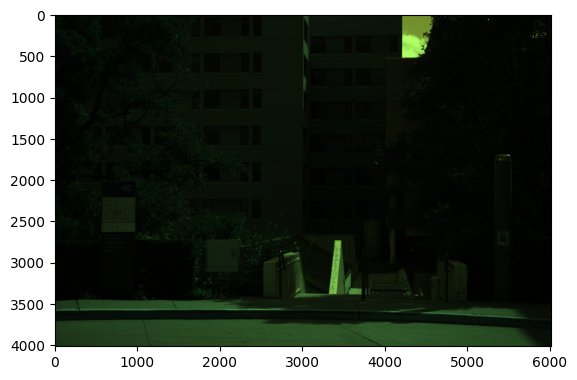

In [48]:
plt.imshow(im_rgb_demosai)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


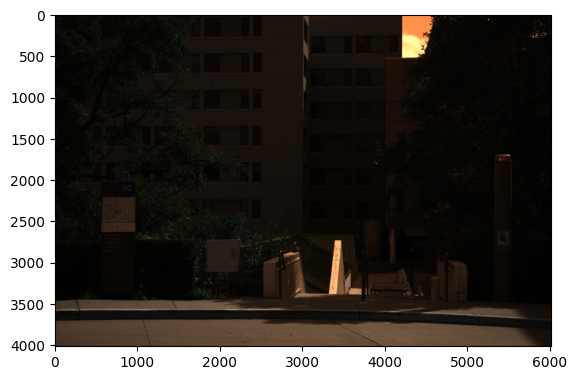

In [102]:
wb_post_demo = preset_white_balancing(im_rgb_demosai)
plt.imshow(wb_post_demo)
plt.show()

In [101]:
# wb_post_demo = white_world_balancing(im_rgb_demosai)
# plt.imshow(im_rgb_demosai)
# plt.show()

"Nikon D3400", 0, 0,
	{ 6988,-1384,-714,-5631,13410,2447,-1485,2204,7318 } 

In [40]:
M_RGB_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
 [0.2126729, 0.7151522, 0.0721750],
 [0.0193339, 0.1191920, 0.9503041]])

M_XYZ_cam = np.array([6988,-1384,-714,-5631,13410,2447,-1485,2204,7318])
M_XYZ_cam = M_XYZ_cam / 10000.0

print(M_XYZ_cam)
M_XYZ_cam = M_XYZ_cam.reshape(3, 3)
print(M_XYZ_cam)
print(M_RGB_XYZ)

[ 0.6988 -0.1384 -0.0714 -0.5631  1.341   0.2447 -0.1485  0.2204  0.7318]
[[ 0.6988 -0.1384 -0.0714]
 [-0.5631  1.341   0.2447]
 [-0.1485  0.2204  0.7318]]
[[0.4124564 0.3575761 0.1804375]
 [0.2126729 0.7151522 0.072175 ]
 [0.0193339 0.119192  0.9503041]]


In [41]:
M_RGB_cam = np.matmul(M_XYZ_cam, M_RGB_XYZ)

In [42]:
norm_factors = M_RGB_cam.sum(axis=1)
norm_factors.shape

(3,)

In [43]:
M_RGB_cam_final = M_RGB_cam / norm_factors.reshape(3,1)

In [44]:
M_RGB_cam_final

array([[ 5.74517316e-01,  3.17795088e-01,  1.07687596e-01],
       [ 5.37863305e-02,  7.33831689e-01,  2.12381981e-01],
       [-2.60393071e-04,  2.18870826e-01,  7.81389567e-01]])

In [50]:
M_RGB_cam_final_ = np.linalg.inv(M_RGB_cam_final)
M_RGB_cam_final_.shape

(3, 3)

In [103]:
# color correction
h, w, c = wb_post_demo.shape
color_corrected = np.matmul(M_RGB_cam_final_, np.transpose(wb_post_demo.reshape(-1, 3)))
print(color_corrected.shape)
color_corrected = np.transpose(color_corrected).reshape(h, w, c)
print(color_corrected.shape)

(3, 24160256)
(4016, 6016, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


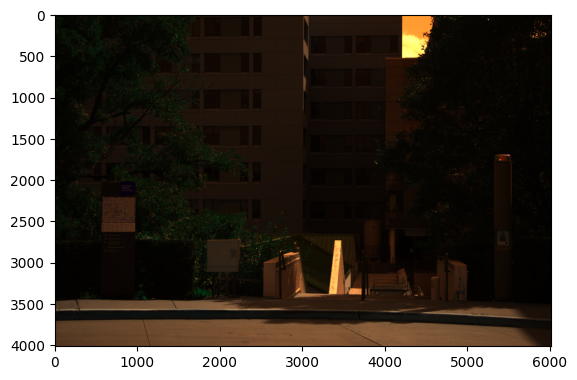

<Figure size 640x480 with 0 Axes>

In [116]:
plt.imshow(color_corrected)
plt.show()
plt.savefig('before_brightness_gamma.png')

In [105]:
def scale_brighten(f):
    # brightness adjustment 
    scaled = color_corrected * f
    return np.clip(scaled, 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


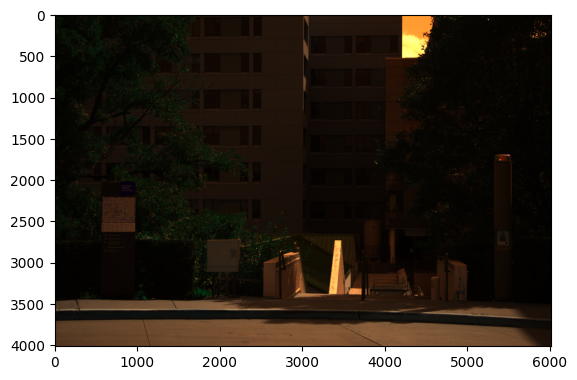

<Figure size 640x480 with 0 Axes>

In [127]:
scale_brighten(0.25)
plt.imshow(color_corrected)
plt.show()
plt.savefig('brighten25.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


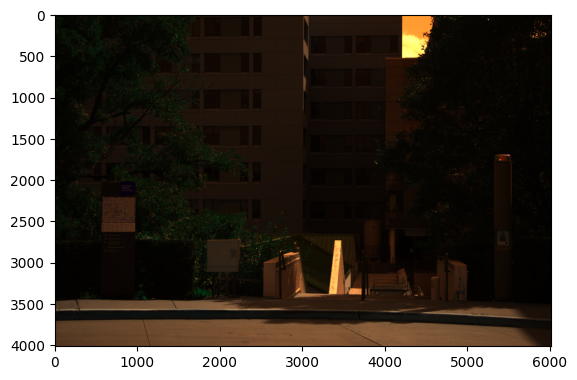

In [107]:
scale_brighten(0.5)
plt.imshow(color_corrected)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


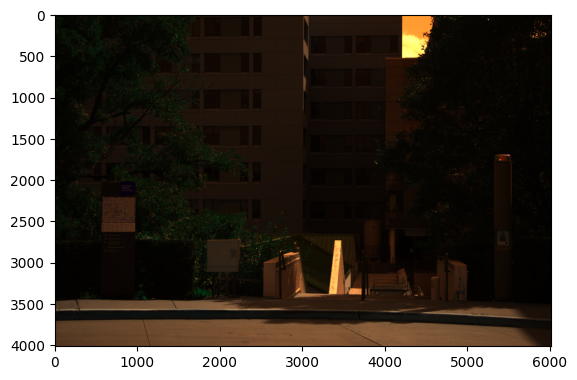

<Figure size 640x480 with 0 Axes>

In [118]:
scale_brighten(0.1)
plt.imshow(color_corrected)
plt.show()
plt.savefig('brighten10.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


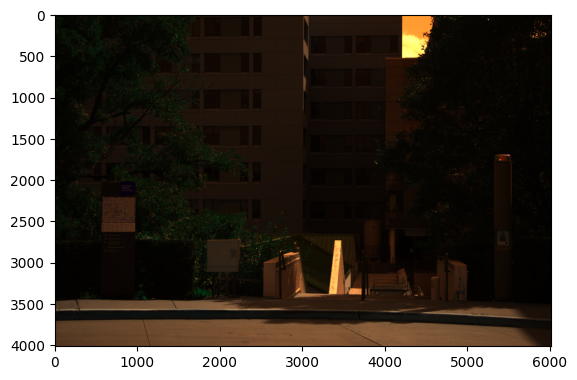

<Figure size 640x480 with 0 Axes>

In [119]:
scale_brighten(0.9)
plt.imshow(color_corrected)
plt.show()
plt.savefig('brighten90.png')

In [110]:
def gamma(C):
    h, w = C.shape
    
    gC = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            if C[i, j] <= 0.0031308:
                gC[i, j] = 12.92 * C[i, j]
            else:
                temp = 1.055 * pow(C[i, j], 0.4167)
                gC[i, j] =  temp - 0.055
    return gC

In [128]:
R = gamma(color_corrected[:, :, 0])

In [129]:
G = gamma(color_corrected[:, :, 1])
B = gamma(color_corrected[:, :, 2])

In [130]:
R_correct = R
G_correct = G
B_correct = B
final = np.dstack((R_correct, G_correct, B_correct))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


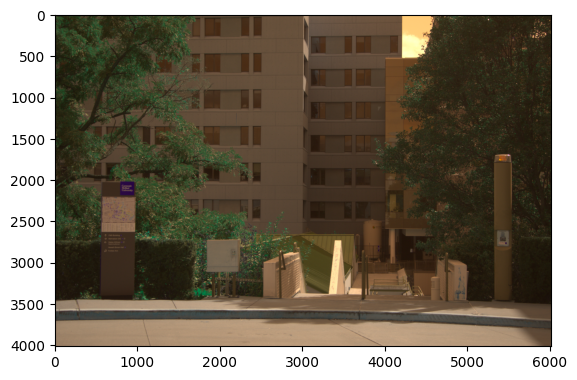

In [131]:
plt.imshow(final)
plt.show()

In [132]:
skimage.io.imsave('final_bggr.png', final)

Lossy conversion from float64 to uint8. Range [-8.158476110134746, 1.7676236229657123]. Convert image to uint8 prior to saving to suppress this warning.


In [133]:
skimage.io.imsave('final_bggr_95.jpeg', final, quality=95)

Lossy conversion from float64 to uint8. Range [-8.158476110134746, 1.7676236229657123]. Convert image to uint8 prior to saving to suppress this warning.


In [134]:
skimage.io.imsave('final_bggr_100.jpeg', final, quality=100)

Lossy conversion from float64 to uint8. Range [-8.158476110134746, 1.7676236229657123]. Convert image to uint8 prior to saving to suppress this warning.


In [135]:
for i in range(40, 80, 10):
    skimage.io.imsave('final_bggr_{}.jpeg'.format(i), final, quality=i)

Lossy conversion from float64 to uint8. Range [-8.158476110134746, 1.7676236229657123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-8.158476110134746, 1.7676236229657123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-8.158476110134746, 1.7676236229657123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-8.158476110134746, 1.7676236229657123]. Convert image to uint8 prior to saving to suppress this warning.


In [136]:
skimage.io.imsave('final_bggr_30.jpeg', final, quality=30)

Lossy conversion from float64 to uint8. Range [-8.158476110134746, 1.7676236229657123]. Convert image to uint8 prior to saving to suppress this warning.
